<div>
  <img style="float: left;"  width="140" src=" 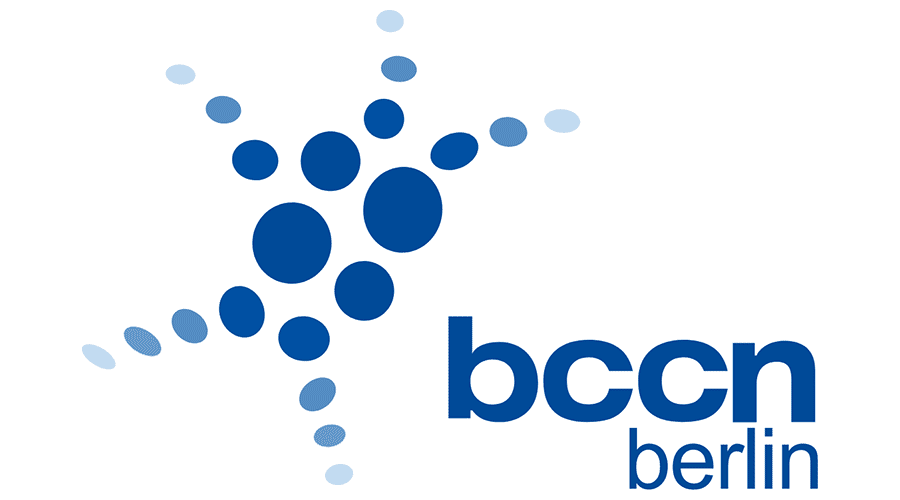">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Models of Higher Brain Functions
        <br>Computer Course
        <br>
    </div>
</h1>
    
---
<div style="text-align: left; float: left">
    Lecturer: Prof. Dr. Henning Sprekeler
</div>

<div style="text-align: right">
    Assistant: Jarek Liesen
    <br>(jarek@bccn-berlin.de)
</div>



# Deep Q-Learning Project (MHBF)

Names: Ahmed Abdalfatah - Arina Belova
Group: "O"

In [ ]:
# Cloning the required files from git directly to avoid pain
!git clone https://github.com/ahmedtarek-/Deep-Q-Learning.git
!cp -r /content/Deep-Q-Learning/gym-grid/gym_grid gym_grid

In [ ]:
# Install required packages
!pip install -q gym==0.15.4
!pip install -q pycolab==1.2
!pip install -q torch==1.2.0
#!pip install -q matplotlib==3.1.2

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim

from IPython import display

#from experience_buffer import ExperienceBuffer

# Part 1 - Environment Implementation

(3, 32, 4)
(6, 14, 5)


/home/galan/anaconda3/envs/rl/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


(6, 14, 5)

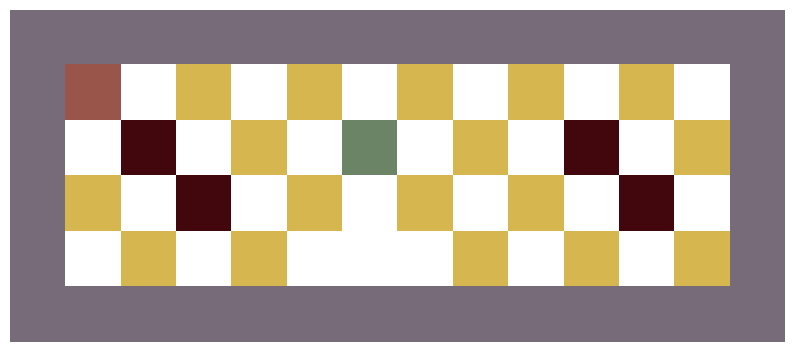

In [3]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# T-Maze Environment
env = gym.make("LinearTrack-v0")
obs, obs_to_render = env.reset_with_render()
print(obs.shape)
env.render(obs_to_render)

# TODO: Deadly Gridworld
env = gym.make("DeadlyGrid-v0")
obs, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
print(obs.shape)

env.observation_space.shape

In [ ]:
env = gym.make("LinearTrack-v0")
obs, obs_to_render = env.reset_with_render()
print(obs.shape)
env.render(obs_to_render)

In [ ]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env.reset_with_render()
env.render(obs_to_render)
rew_total = 0
for i in range(50):
    action = env.action_space.sample()
    _, rew , done, _, obs_to_render = env.step_with_render(action)
    env.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)
print(action)

# Part 2 - Deep Q-Learning Agents

In [ ]:
# PLAYGROUND CELL
states = env.observation_space.shape
actions = env.action_space.n

env.observation_space.shape

### 1) Defining Network

In [2]:
random.seed(42)
bs = 128

# Simple MLP class

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, dim_input, dim_output):
    super().__init__()

    self.layers = nn.Sequential(OrderedDict([
    ('hidden', nn.Linear(dim_input, 128)),
    ('act', nn.ReLU()),
    ('output', nn.Linear(128, dim_output)),
    # maybe we want this as well ('outact', nn.Sigmoid()),
    ]))

    # init weights, maybe Xavier init?
    self.layers.apply(self.init_weights)

  def init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.xavier_uniform_(module.weight)
      module.bias.data.fill_(0.01)

  def forward(self, x):
      return self.layers(x)

### 2) Defining policy

In [3]:
# TODO: try exponentially annealing epsilon-greedy from 1-> 0
# s\left(\frac{t}{s}\right)^{x}

# TODO: only 80% of steps should linearly anneal!

def eps_greedy(q, e):
  rand = np.random.uniform(0, 1)
  if len(q.shape) == 1:
    q = torch.unsqueeze(q, dim=0)

  #print(q)
  if rand <= (1 - e):
    #chosen_action = torch.argmax(q, dim=1).item()
    chosen_action = torch.argmax(q, dim=1)
    q_value = q[np.arange(len(q)), chosen_action]
  else:
    chosen_action = np.random.choice(range(q.shape[1]))
    q_value = q[:,chosen_action]

  return chosen_action, q_value

### 3) Defining Y_hat

In [4]:
def calculate_y_hat(reward, max_next_q, done, gamma=0.99):
  #return torch.Tensor([reward + gamma * (1 - done) * max_next_q.detach().numpy()])
  return reward.squeeze() + gamma * (torch.ones(done.shape[0]) - done.squeeze()) * max_next_q.detach()

In [6]:
def rollout_episode(env_name, model, policy, eval_steps, gamma = 0.99):
    model.eval()
    rew_total = 0
    discounter_reward = 0
    # TODO: should we really do reset of the env?
    # We need a separate testing environment!!!
    env = gym.make(env_name)
    current_state = env.reset()

    # Multiple episodes not steps!!! And avg discounted reward over episodes.
    for t in range(eval_steps):
        # use the epsilon greedy policy with a ver small epsilon = 0.01 
        q = model(torch.Tensor(current_state.flatten()))    
        action, _ = policy(q, e = 0.01)
        new_state, rew , done, _ = env.step(action)
        rew_total += rew
        discounter_reward += rew * pow(gamma, t)
        current_state = torch.Tensor(new_state.flatten()) 
        
        if done:
            break
      
    model.train() 
    return rew_total, discounter_reward, done       

### 2) Defining main loop

In [7]:
class ExperienceBatch():
  def __init__(self, current_states, actions, rewards, next_states, done):
    self.current_states = current_states
    self.actions = actions
    self.rewards = rewards
    self.next_states = next_states
    self.done = done

  def get_current_states(self):
    return torch.Tensor(self.current_states)

  def get_actions(self):
    return torch.Tensor(self.actions)

  def get_rewards(self):
    return torch.Tensor(self.rewards)

  def get_next_states(self):
    return torch.Tensor(self.next_states)

  def get_done(self):
    return torch.Tensor(self.done)  

  def size(self):
    return self.actions.shape[0]

  def items(self):
    """
    ACHTUNG: not so effecient; more for testing than using in training
    """
    return list(zip(self.current_states, self.actions, self.rewards, self.next_states, self.done))


class ExperienceBuffer():
  DEFAULT_BATCH_SIZE = 128

  def __init__(self, shape, batch_size = DEFAULT_BATCH_SIZE, capacity=1000):
    """
      Parameters:
        - shape: Describes the size of each component.
          Example:
            - A 'state' is represented by 420 numbers
            - Reward is a scalar value
            - Action is a scalar value
            - Then the shape will be (420, 1, 1, 420)
        - capacity: Defines the total capacity of the buffer
    """
    # self.batch_size = batch_size
    # self.capacity = capacity
    # self.current_index = 0
    # self.current_states = np.zeros((capacity, shape[0]))
    # self.actions = np.zeros((capacity, shape[1]))
    # self.rewards = np.zeros((capacity, shape[2]))
    # self.next_states = np.zeros((capacity, shape[3]))
    # self.done = np.zeros((capacity, shape[4]))
    
    self.batch_size = batch_size
    self.capacity = capacity
    self.current_index = 0
    self.current_states = np.zeros((capacity, shape[0])) - 1
    self.actions = np.zeros((capacity, shape[1])) - 1
    self.rewards = np.zeros((capacity, shape[2])) - 1
    self.next_states = np.zeros((capacity, shape[3])) - 1
    self.done = np.zeros((capacity, shape[4])) - 1

  def add(self, current_state, action: int, reward: int, next_state, done: int) -> None:
    self.current_states[self.current_index] = current_state
    self.actions[self.current_index] = action
    self.rewards[self.current_index] = reward
    self.next_states[self.current_index] = next_state
    self.done[self.current_index] = done
    
    self.update_index()

  def update_index(self) -> None:
    """
    Updates the index that is being used to populate the buffer; 
    the 'current_index' is set to 0 whenever we reach the end of the buffer
    to override the very first values that were added (FIFO).
    """
    if self.current_index == (self.capacity - 1):
      self.current_index = 0
    else:
      self.current_index += 1

  # As long th buffer is not full we don't update NN, no gradient update
  def get_next(self) -> ExperienceBatch:
    """
    If the buffer hasn't reached the 'buffer_size' yet, then we return a batch
    representing all the data in the buffer. Otherwise we sample 'buffer_size' 
    items from the buffer.
    """
    if self.size() <= self.batch_size:
      # Case A: Current buffer size is smaller than requested => Return all items
      indices = np.arange(0, self.size())
    elif self.batch_size == 1:
      # Case B: Requested batch size is 1 => Return last item
      indices = [self.current_index - 1]
    else:
      # Case C: Requested batch size is smaller to buffer size => Sample from available items
      indices = np.random.choice(self.size(), size=self.batch_size, replace=False)
    return ExperienceBatch(*self.items(indices))

  def size(self) -> int:
    return np.count_nonzero(self.actions != -1)

  def items(self, indices=None) -> tuple:
    return (self.current_states[indices],
      self.actions[indices],
      self.rewards[indices],
      self.next_states[indices],
      self.done[indices]
    )

  def __str__(self) -> str:
    return f"""
      Capacity: {self.capacity}
      Size: {self.size()}
      Current Index: {self.current_index}
      Shape: ({self.current_states.shape[1]},{self.actions.shape[1]},{self.rewards.shape[1]},{self.next_states.shape[1]}, {self.done.shape[1]})
    """

In [9]:
# https://spinningup.openai.com/en/latest/algorithms/ddpg.html
# http://karpathy.github.io/2016/05/31/rl/
# https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-4643c1f71b2e

def the_loop(model, env_name, loss_function, exp_replay = False, num_update_steps = 20000, num_episodes = 50, policy = eps_greedy, eval_steps = 20, evaluate_at = 500):
  # episodes num = 50/100 and updates = 20000/100000
  #for update_step in range(num_update_steps):
  env = gym.make(env_name)
  rew_inter_arr = np.zeros(int(num_update_steps / evaluate_at))
  discounted_rew_arr = np.zeros(int(num_update_steps / evaluate_at))
  counter = 0
  sample_size = np.prod(env.observation_space.shape)

  # So epsilon decays only in 80% of the steps and in first 20% of the steps it stays fully exploratative (epsilon = 1)
  epsilon = lambda count: 1 * (1 - ((count + 1) / num_update_steps)) if count >= 0.2 * num_update_steps else 1

  if exp_replay:
    exp_buffer = ExperienceBuffer((sample_size,1,1,sample_size,1))
  else:
    exp_buffer = ExperienceBuffer((sample_size,1,1,sample_size,1), batch_size = 1) 

  # TODO: num of episodes * num_steps_in_episode = 20000
  while counter < num_update_steps:
    #print(update_step)
    current_state = env.reset()
    current_state_tensor = torch.Tensor(current_state.flatten())

    # TODO: num steps in the episode = 50
    # num episodes is not fixed!
    for _ in range(num_episodes):

      # 1. Forward pass on NN to get the Q(t)
      q_t = model(current_state_tensor).detach()

      # 2. Decide which action to choose based on annealing epsilon greedy policy
      # TODO: # sigmoid schedule on the epsilon so we have more exploration. We need to do annealing for 80% of steps
      # Clipping
      chosen_action, current_q_value = policy(q_t, e = epsilon(counter))
      #print(f"Current q value is {current_q_value}")

      # 3. Take action/step and get reward and next state
      next_state, reward , done, _ = env.step(chosen_action)

      # 4. Run another forward pass to get all q_values for next_state
      next_state_tensor = torch.Tensor(next_state.flatten())

      # 4(a). Store in experence replay buffer:
      #print(current_state_tensor)
      exp_buffer.add(current_state_tensor, chosen_action, reward, next_state_tensor, done)

      # Important previously: current_state_tensor = next_state_tensor
      current_state_tensor = next_state_tensor

      # WIP: Now we ask for a batch and we update the gradient wrt batch 
      # first check is whether we have sufficiently full buffer
      # TODO: thnk about case 1
      if counter >= exp_buffer.batch_size:
        buffer_batch = exp_buffer.get_next()

        q_current_t = model(buffer_batch.get_current_states())
        #print(f"Current q shape: {q_current_t.shape}")
        _, current_max_q_value = policy(q_current_t, e = epsilon(counter))
        #print(f"Current q after policy shape: {current_max_q_value.shape}")

        q_next_t = model(buffer_batch.get_next_states()) # will be a matrix of Qs (buffer_size x num_actions)
        #print(f"Next q shape is: {q_next_t.shape}")

        # 5. Get maximum q_value, greedy action
        _, next_max_q_value = policy(q_next_t, e = 0)
        #print(f"Next max q shape is: {next_max_q_value.shape}")   #Next max q shape is: torch.Size([128, 128])
        #print(next_max_q_value)
        #next_max_q_value, q_next_t
        
        # 6. Calculate Y_hat
        #print(f"Rewards dimension is {buffer_batch.get_rewards().shape}") #[128, 1]
        #print(f"Next max q shape is: {next_max_q_value.shape}") #[128]
        #print(f"Done dimension is: {(buffer_batch.get_done() * 1).shape}") #[128,1]
        y_hat = calculate_y_hat(buffer_batch.get_rewards(), next_max_q_value, buffer_batch.get_done() * 1).detach()
        #print(f"Y hat dimension is: {y_hat.shape}")

        # 7. Loss function: input, target
        loss = loss_function(y_hat, current_max_q_value)
        #print(current_max_q_value.shape)
        #print(y_hat.shape)

        # 8. Backpropagate to learn
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   

      # 9. TODO: Do the evaluation every 500 steps
      # run in the env under greedy policy to get running reward
      if (counter % evaluate_at) == 0:
        with torch.no_grad():
          rew_intermediate, discounted_rew, rollout_done = rollout_episode(env_name, model, policy, eval_steps)  
          #print(f"Current index {int(counter / evaluate_steps)}")
          rew_inter_arr[int(counter / evaluate_at)] = rew_intermediate
          discounted_rew_arr[int(counter / evaluate_at)] = discounted_rew
          print(f"Intermediate reward at idx {int(counter / evaluate_at)} update is {rew_intermediate}")  
          print(f"Discounted reward at idx {int(counter / evaluate_at)} update is {discounted_rew}")
          
        if rollout_done:
          break    
      
      # step counter
      counter += 1

      # 10. Check if we terminate an episode due to one of the termination conditions
      if done:
        break

      # 11. Check if we're out of updating for good.
      if counter >= num_update_steps:
        break

  return rew_inter_arr, discounted_rew_arr

      # YAAAY repeat now

**Questions:**

 - Linearly Annealing epsilon greedy poicy
 - Correctness of termination condition
 - MSBE loss looks like MSE loss between current state and update. Yes it is the same


In [13]:
# just to get configurations for the model
env = gym.make("LinearTrack-v0")

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

lr = 0.001
model = MLP(states, actions)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

rew_inter_arr, discounted_rew_arr = the_loop(model = model, env_name = "LinearTrack-v0", loss_function = loss_func, exp_replay = True, eval_steps = 5)

# Save the model weights
#torch.save(model.state_dict(), "models/vanilla_linear_track_with_exp_replay.pt")

Intermediate reward at idx 0 update is 0
Discounted reward at idx 0 update is 0.0
Intermediate reward at idx 1 update is 0
Discounted reward at idx 1 update is 0.0
Intermediate reward at idx 2 update is 0
Discounted reward at idx 2 update is 0.0
Intermediate reward at idx 3 update is 0
Discounted reward at idx 3 update is 0.0
Intermediate reward at idx 4 update is 0
Discounted reward at idx 4 update is 0.0
Intermediate reward at idx 5 update is 200
Discounted reward at idx 5 update is 198.0
Intermediate reward at idx 6 update is 0
Discounted reward at idx 6 update is 0.0
Intermediate reward at idx 7 update is 0
Discounted reward at idx 7 update is 0.0
Intermediate reward at idx 8 update is 0
Discounted reward at idx 8 update is 0.0
Intermediate reward at idx 9 update is 0
Discounted reward at idx 9 update is 0.0
Intermediate reward at idx 10 update is 0
Discounted reward at idx 10 update is 0.0
Intermediate reward at idx 11 update is 0
Discounted reward at idx 11 update is 0.0
Intermed

In [10]:
env = gym.make("DeadlyGrid-v0")

states = np.prod(env.observation_space.shape)
actions = env.action_space.n

lr = 0.001
model = MLP(states, actions)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

rew_inter_arr, discounted_rew_arr = the_loop(model, "DeadlyGrid-v0", loss_func, exp_replay = True, num_update_steps = 500000, num_episodes = 100, eval_steps = 40)



/home/galan/anaconda3/envs/rl/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


Intermediate reward at idx 0 update is 0
Discounted reward at idx 0 update is 0.0
Intermediate reward at idx 1 update is 0
Discounted reward at idx 1 update is 0.0
Intermediate reward at idx 2 update is 0
Discounted reward at idx 2 update is 0.0
Intermediate reward at idx 3 update is 0
Discounted reward at idx 3 update is 0.0
Intermediate reward at idx 4 update is 100
Discounted reward at idx 4 update is 99.0
Intermediate reward at idx 5 update is 0
Discounted reward at idx 5 update is 0.0
Intermediate reward at idx 6 update is 0
Discounted reward at idx 6 update is 0.0
Intermediate reward at idx 7 update is 0
Discounted reward at idx 7 update is 0.0
Intermediate reward at idx 8 update is 100
Discounted reward at idx 8 update is 99.0
Intermediate reward at idx 9 update is 100
Discounted reward at idx 9 update is 97.0299
Intermediate reward at idx 10 update is 0
Discounted reward at idx 10 update is 0.0
Intermediate reward at idx 11 update is 100
Discounted reward at idx 11 update is 99

In [17]:
# Save the model weights
torch.save(model.state_dict(), "../models/2d_track_with_exp_replay_50K.pt")

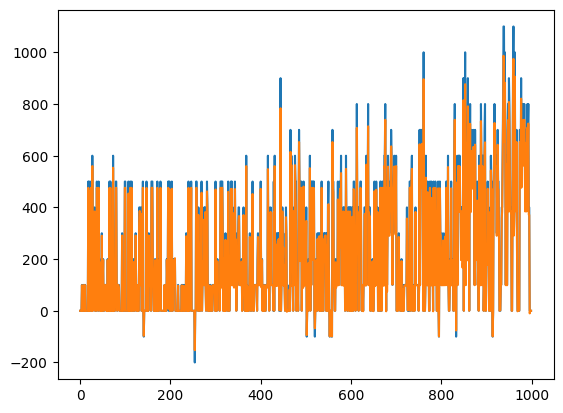

In [11]:
plt.plot(rew_inter_arr)
plt.plot(discounted_rew_arr)

The total reward in this episode is: 0


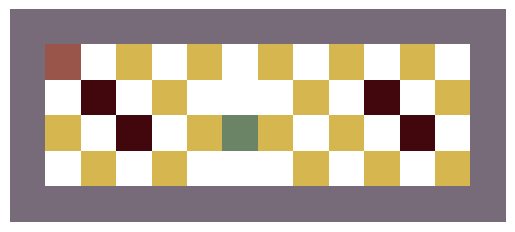

In [18]:

env_2d = gym.make("DeadlyGrid-v0")

model = load_model_env(env_2d, "../models/2d_track_with_exp_replay_50K.pt")
run_trained_model_visual(env_2d, model, num_steps=50)

In [12]:
def load_model_env(env, path_to_model):
    states = np.prod(env.observation_space.shape)
    actions = env.action_space.n

    m_load = MLP(states, actions) 
    m_load.load_state_dict(torch.load(path_to_model))

    return m_load

In [17]:
env_linear = gym.make("LinearTrack-v0")
env_2d = gym.make("DeadlyGrid-v0")

no_exp_replay = load_model_env(env_linear, "models/vanilla_linear_track_no_exp_replay.pt")

with_exp_replay = load_model_env(env_linear, "models/vanilla_linear_track_with_exp_replay.pt")

with_exp_replay_2d = load_model_env(env_2d, "models/2d_track_with_exp_replay.pt")

In [ ]:
m_gold = load_model_env(env_linear, "models/vanilla_linear_track_upd.pt")

In [ ]:
m_diamond = load_model_env(env_linear, "models/vanilla_linear_track_diamond.pt")

In [13]:
def run_trained_model_visual(env, model, num_steps = 20):
    current_state, obs_to_render = env.reset_with_render()
    env.render(obs_to_render)
    rew_total = 0

    # put the model in inference mode
    model.eval()
    done = False 

    for _ in range(num_steps):
        action = torch.argmax(model(torch.Tensor(current_state.flatten()))).item()    
        current_state, rew , done, _, obs_to_render = env.step_with_render(action)
        env.render(obs_to_render)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        rew_total += rew

        if done:
            break
        
    print(f"The total reward in this episode is: {rew_total}")

In [ ]:
# TODO: WHY THE FUCK IT STARTS IN THE MIDDLE OF THE GRID???????
run_trained_model_visual(env_2d, with_exp_replay_2d)

In [ ]:
run_trained_model_visual(env_linear, no_exp_replay)

In [ ]:
run_trained_model_visual(env_linear, with_exp_replay)

In [ ]:
run_trained_model_visual(env_linear, m_gold)

In [ ]:
# Ths 30 mins of training
run_trained_model_visual(env_linear, m_diamond)

Note for the report:

This weird behaviour of aquiring a diamond was due to the fact that the model was updating its gradient for 20000 * 50 times instead of just 20000.
And consequently, it took almost eternity to do so:) 

# Ideas: 

In the definition of environment:
- Create a small negative reward (-10) for every step taken
- Create a negative reward (-100) for the wall hitting 
- Decrease discount fact to be more miopic
- Implement exponentially annealing epsilon

### Deadly grid

In [ ]:
env_grid = gym.make("DeadlyGrid-v0")
obs, obs_to_render = env_grid.reset_with_render()
env_grid.render(obs_to_render)

In [ ]:
states_grid = np.prod(env_grid.observation_space.shape)
actions_grid = env_grid.action_space.n

lr = 0.001
model = MLP(states_grid, actions_grid)

# Defining the loss function
loss_func = nn.MSELoss()

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#print(model.layers[2].weight)
rew_inter_arr, discounted_rew_arr = the_loop(model, env_grid, loss_func, num_update_steps = 100000, num_episodes = 100, eval_steps = 20)
#print(model.layers[2].weight)

# Save the model weights
torch.save(model.state_dict(), "models/vanilla_2d_track.pt")

In [ ]:
plt.plot(np.arange(0, 100000, 500), rew_inter_arr)

In [ ]:
m_grid = load_model_env(env_grid, "models/vanilla_2d_track.pt")
run_trained_model_visual(env_grid, m_grid)

# Experience replay:

Let's add experience replay to this dumb agent above in hope that it will remember some cool transitions from the past:

In [ ]:
# Example on how to use this mofo?

# A) Initialize with shape tuple (assuming state is represented by 4 values)
exp_buffer = ExperienceBuffer((4,1,1,4))

# B) Add some items to the buffer (5 items)
exp_buffer.add(np.array([1,2,3,4]), 1, 2, np.array([1,2,3,90]))
exp_buffer.add(np.array([10,20,30,40]), 1, 0, np.array([1,2,3,90]))
exp_buffer.add(np.array([1000,20,30,4000]), 1, 0, np.array([12,22,32,290]))
exp_buffer.add(np.array([1,2,3,4]), 3, 2, np.array([0,0,0,0]))
exp_buffer.add(np.array([1,1,1,1]), 3, 1, np.array([1,2,3,90]))

# C) Get a batch using a batch_size bigger than number of items (all items)
exp_batch = exp_buffer.get_next()
print(exp_batch.rewards)

# D) Get a batch using a batch_size smaller than number of items (random sample)
exp_batch = exp_buffer.get_next(batch_size=2)
print(exp_batch.rewards)

# E) Just printing the buffer stats
print(exp_buffer)

In [ ]:
# Let's try to train the model with experience replay buffer:
